# Compare TMA balancing data from previous events with the next events

We are getting ready to balance the telescope twice in the next weeks. First, we will balance the telescope with ComCam and M2 Glass. The M2 Glass and M2 Surrogate have similar weights, with a small difference. We expect the torques applied by the elevation drives will be very close to the previous balancing event(s). A couple of weeks later, we will repeat the procedure with ComCam, M2 Glass, and M1M3 Glass. The M1M3 Glass and M1M3 Cell assembly is much heavier than the M1M3 Mass Simulator (yellow cross) and hundreds of kilograms heavier than the M1M3 Surrogate and M1M3 Cell configuration. This procedure will be much more delicate due to the size and mass of the mirror.

We want to establish a baseline before we start the procedure, and we need someone to review the data to determine whether we can proceed quickly.

The links below point to old night logs that might contain useful information. Feel free to unlink them if they are not useful.

Here is an approximate timeline of different integration phases where we needed to re-balance the telescope. We do not necessarily need the whole process. We need the torques once the telescope is already balanced as a baseline.

May to Aug 2023 - M1M3 Surrogate and M1M3 Cell on the TMA

Nov 2023 to Jan 2024 - M1M3 Surrogate and Cell, M2 Surrogate and Cell on the TMA

Feb to Apr 2024 - M2 Surrogate and Cell on the TMA

## Setup notebook

Note that we have to `pip install DateTimeRange` in order to easily find the overlap between 2 time ranges

In [1]:
# Notebook extensions for formatting and auto-reload libraries
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

# Standard Python Libraries
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

from astropy.time import Time, TimeDelta
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
from datetimerange import DateTimeRange

# LSST Specific Libraries
from lsst_efd_client import EfdClient
from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import (
    getCommandsDuringEvent,
    TMAEvent,
    TMAEventMaker,
    TMAState,
)

## Identify time periods with telemetry and where the TMA is still

In order to do that we will check the "lsst.sal.MTMount.logevent_elevationMotionState" and "lsst.sal.MTMount.logevent_azimuthMotionState" topics and select time ranges where
the `state` is equal to 1, meaning that the TMA is `stopped`

Once we have the time ranges in both azimuth and elevation we select the overlaps between both sets.

In [2]:
async def get_time_range_by_axis(client, TMA_axis, begin, end):
    """
    Query the status of the TMA on a given axis (elevation or azimuth) during a time window and return
    a list of time ranges where the TMA  is still on this axis.

    Args:
        client: EFD client

        TMA_axis (str): Axis of the TMA to be checked ("elevation" or "azimuth").

        begin (Time) : Starting time

        end (Time) : End time

    Returns:
        time_range (list of DateTimeRange) : Range of times where the TMA is still on the considered TMA_axis
    """

    topic = f"lsst.sal.MTMount.logevent_{TMA_axis}MotionState"
    df_status = getEfdData(client, topic, begin=begin, end=end)
    if len(df_status) == 0:
        print(f"No status data found for {TMA_axis} axis, using full time range")
        time_ranges = [
            DateTimeRange(
                pd.Timestamp(start_time.datetime64, tz="UTC"),
                pd.Timestamp(end_time.datetime64, tz="UTC"),
            )
        ]
        return time_ranges

    select_stopped = df_status["state"] == 1

    # Select rows corresponding to motion state == stopped
    i_start = np.array(
        [
            df_status.index.get_loc(df_status[select_stopped].index[i])
            for i in range(len(df_status[select_stopped]))
        ]
    )
    t_start = list(df_status["state"].index[i_start])
    if i_start[-1] < len(df_status) - 1:
        t_end = list(df_status["state"].index[i_start + 1])
    else:
        t_end = list(df_status["state"].index[i_start[0:-1] + 1])
        t_end.append(pd.Timestamp(end_time.datetime64, tz="UTC"))

    time_ranges = []
    for i, (t1, t2) in enumerate(zip(t_start, t_end)):
        time_ranges.append(DateTimeRange(t1, t2))

    return time_ranges


def get_overlaps(t_range_1, t_range_2, min_delta):
    """
    Find the time overlaps between two lists of DateTimeRange. The overlap will only be considered if its duration is
    > min_delta seconds

    Args:
        t_range_1 (list of DateTimeRange)
        t_range_2 (list of DateTimeRange)
        min_delta (int) minimum duration in seconds of the time overlap

    Return:
        overlaps (list of DateTimeRange)
    """
    overlaps = []
    for r1 in t_range_1:
        for r2 in t_range_2:
            t_range_ok = r1.intersection(r2)
            if (t_range_ok.start_datetime != None) and (
                t_range_ok.timedelta.total_seconds() > min_delta
            ):
                overlaps.append(
                    DateTimeRange(t_range_ok.start_datetime, t_range_ok.end_datetime)
                )

    return overlaps

In [3]:
def get_common_azimuth(overlaps, client):
    """
    Within all the time periods where the TMA is still in both azimuth and elevation, find the most common azimuth position.
    Returns the minimum and maximum azimuth values to be retaine in the analysis.

    Args:
        overlaps: list of selected DateTimeRange

        client: EFD client

    Returns:
        az_min (float) : minimum azimuth value

        az_max (float) : maximum azimuth value
    """

    columns = ["actualVelocity", "actualTorque", "actualPosition"]
    mean_pos_azi = []
    std_pos_azi = []
    for overlap in overlaps:
        df_azi = getEfdData(
            client,
            "lsst.sal.MTMount.azimuth",
            columns=columns,
            begin=Time(overlap.start_datetime),
            end=Time(overlap.end_datetime),
        )
        if len(df_azi) > 0:
            mean_pos_azi.append(np.mean(df_azi["actualPosition"]))
            std_pos_azi.append(np.std(df_azi["actualPosition"]))

    # Find the most common TMA position in azimuth
    hist = np.histogram(mean_pos_azi, bins=180)
    imax = np.array(hist[0]).argmax()
    az_min = hist[1][imax]
    az_max = hist[1][imax + 1]
    sel_azi = (az_min + az_max) / 2
    print(
        f"The most common TMA azimuth angle is: {sel_azi:.1f} degrees - # of occurences: {hist[0][imax]}"
    )

    return az_min, az_max

In [4]:
def make_dataframe(overlaps, client, az_min, az_max):
    """
    Retrieve data corresponding to the identified time ranges, clean-up the dataset and return a pandas dataframe with the relevant EFD information.
    Only data where the TMA azimuth position is between az_min and az_max are retained

    Args:
        overlaps: list of selected DateTimeRange

        client: EFD client

        az_min (float) : minimum azimuth value

        az_max (float) : maximum azimuth value

    Returns:
        df : pandas dataframe containing the seleted relevant EFD information
    """

    cut_std_azi = 1  # Cut on the standard deviation of the azimuth position
    cut_torque = 5000  # We want the torque measurement to be stable for a given position in elevation. This is an absolute cut on the standard deviation (in N.m)
    cut_mean_ele = 5  # We want to exclude measurements when the elevation angle is too small (cut in degrees)

    # we get rid of the first dt seconds to let enough time for the TMA to settle
    dt = TimeDelta(10, format="sec")

    look_back = TimeDelta(
        3600, format="sec"
    )  # Look back time in seconds to retrieve the rotation direction of the last TMA movement in elevation

    mean_torque_ele = []
    std_torque_ele = []
    mean_pos_ele = []
    std_pos_ele = []
    mean_torque_azi = []
    std_torque_azi = []
    mean_pos_azi = []
    std_pos_azi = []
    mean_vel_azi = []
    mean_vel_ele = []
    ts_start = []
    ts_end = []
    direction = []

    columns = ["actualVelocity", "actualTorque", "actualPosition", "actualVelocity"]

    for i, overlap in enumerate(overlaps):
        df_ele = getEfdData(
            client,
            "lsst.sal.MTMount.elevation",
            columns=columns,
            begin=Time(overlap.start_datetime) + dt,
            end=Time(overlap.end_datetime),
        )
        df_azi = getEfdData(
            client,
            "lsst.sal.MTMount.azimuth",
            columns=columns,
            begin=Time(overlap.start_datetime),
            end=Time(overlap.end_datetime),
        )
        if (len(df_ele) == 0) or (len(df_azi) == 0):
            continue

        if (
            (np.mean(df_azi["actualPosition"]) > az_min)
            & (np.mean(df_azi["actualPosition"]) <= az_max)
            & (np.mean(df_ele["actualPosition"]) > cut_mean_ele)
            & (np.std(df_azi["actualPosition"]) < cut_std_azi)
            & (np.std(df_ele["actualTorque"]) < cut_torque)
        ):
            mean_pos_azi.append(np.mean(df_azi["actualPosition"]))
            std_pos_azi.append(np.std(df_azi["actualPosition"]))
            mean_torque_ele.append(np.mean(df_ele["actualTorque"]))
            std_torque_ele.append(np.std(df_ele["actualTorque"]))
            mean_pos_ele.append(np.mean(df_ele["actualPosition"]))
            std_pos_ele.append(np.std(df_ele["actualPosition"]))
            mean_torque_azi.append(np.mean(df_azi["actualTorque"]))
            std_torque_azi.append(np.std(df_azi["actualTorque"]))
            mean_vel_ele.append(np.mean(df_ele["actualVelocity"]))
            ts_start.append(df_ele.index[0])
            ts_end.append(df_ele.index[-1])

            # Look back in time to retrieve the rotation direction of the last TMA movement in elevation and in azimuth

            df_ele_back = getEfdData(
                client,
                "lsst.sal.MTMount.elevation",
                columns=["actualVelocity"],
                begin=Time(overlap.start_datetime) - look_back,
                end=Time(overlap.start_datetime),
            )
            cut_speed = np.abs(df_ele_back["actualVelocity"]) > 0.01
            direction.append(np.sign(df_ele_back["actualVelocity"][cut_speed].iloc[-1]))

            df_azi_back = getEfdData(
                client,
                "lsst.sal.MTMount.azimuth",
                columns=["actualVelocity"],
                begin=Time(overlap.start_datetime) - look_back,
                end=Time(overlap.start_datetime),
            )
            cut_speed = np.abs(df_azi_back["actualVelocity"]) > 0.01

    data = {
        "ts_start": ts_start,
        "ts_end": ts_end,
        "mean_torque": mean_torque_ele,
        "std_torque": std_torque_ele,
        "mean_pos": mean_pos_ele,
        "std_pos": std_pos_ele,
        "mean_pos_azi": mean_pos_azi,
        "mean_vel": mean_vel_ele,
        "direction": direction,
    }
    df = pd.DataFrame(data)

    return df

In [5]:
def plot_torque_versus_elevation(df, date, sel_azi, plot_dir, save_plot=True):
    """
    Plot torque versus elevation angle for the df dataframe

    Args:
        df : pandas dataframe

        date (str) : data acquisition date

        sel_azi (float) : selected azimuth angle

        plot_dir (str) : path name to save plots

        save_plot (bool): save plot if True
    """

    y_span = df["mean_torque"].max() - df["mean_torque"].min()

    fig, ax = plt.subplots(1, dpi=125, figsize=(10, 6))

    cut_pos = df["direction"] > 0
    cut_neg = df["direction"] < 0
    ax.errorbar(
        df["mean_pos"][cut_pos],
        df["mean_torque"][cut_pos],
        xerr=df["std_pos"][cut_pos],
        yerr=df["std_torque"][cut_pos],
        fmt=".",
        c="g",
        label="+ rotation",
    )
    ax.errorbar(
        df["mean_pos"][cut_neg],
        df["mean_torque"][cut_neg],
        xerr=df["std_pos"][cut_neg],
        yerr=df["std_torque"][cut_neg],
        fmt=".",
        c="r",
        label="- rotation",
    )
    ax.set_xlabel("Elevation (degrees)")
    ax.set_ylabel("Elevation torque (N.m)")
    ax.set_xlim([0, 95])

    for i in range(len(df)):
        ax.text(
            df["mean_pos"][i] + i % 2,
            df["mean_torque"][i] + ((i + 1) % 2) * y_span / 100,
            f"{i}",
        )

    ax.legend()

    fig.suptitle(f"{date} - Azimuth position: {sel_azi:.1f} degrees")
    fig.tight_layout()
    if save_plot:
        plt.savefig(f"{plot_dir}/Torque-Elevavtion-{date}-Az-{sel_azi:.1f}.png")
    plt.show()

    return

In [6]:
def plot_history(df, client, t_back, date, sel_azi, plot_dir, save_plot=True):
    """
    look back in time and plot some values in chronological order. Mainly for sanity check

    Args:
        df : pandas dataframe

        client : EFD client

        t_back (int) : number of seconds to look back in time

        date (str) : data acquisition date

        sel_azi (float) : selected azimuth angle

        plot_dir (str) : path name to save plots

        save_plot (bool): save plot if True
    """

    dt = TimeDelta(t_back, format="sec")
    begin = Time(df["ts_start"][0]) - dt
    end = Time(df["ts_end"][len(df) - 1])
    columns = ["actualVelocity", "actualTorque", "actualPosition", "actualVelocity"]
    df_ele_2 = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=columns,
        begin=begin,
        end=end,
    )
    df_azi_2 = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=columns,
        begin=begin,
        end=end,
    )

    fig, ax = plt.subplots(4, 1, sharex=True, dpi=125, figsize=(12, 5))
    ax[0].plot(df_ele_2.index, df_ele_2["actualPosition"])
    ax[1].plot(df_ele_2.index, df_ele_2["actualTorque"])
    # ax[1].set_yscale("log")
    t_min = df["mean_torque"].min()
    t_max = df["mean_torque"].max()
    y_span = t_max - t_min
    ax[1].set_ylim([t_min - y_span / 20, t_max + y_span / 20])
    ax[2].plot(df_azi_2.index, df_azi_2["actualPosition"])
    ax[3].plot(df_ele_2.index, df_ele_2["actualVelocity"])

    cut_pos = df["direction"] > 0
    cut_neg = df["direction"] < 0
    p_rot_flag = True
    n_rot_flag = True
    for i in range(0, len(df)):
        if df["direction"][i] > 0:
            color = "g"
            if p_rot_flag:
                label = "+ rotation"
                p_rot_flag = False
            else:
                label = ""
        else:
            color = "r"
            if n_rot_flag:
                label = "- rotation"
                n_rot_flag = False
            else:
                label = ""
        ax[0].hlines(
            df["mean_pos"][i] + 5,
            xmin=df["ts_start"][i],
            xmax=df["ts_end"][i],
            color=color,
            label=label,
        )
        ax[2].hlines(
            55,
            xmin=df["ts_start"][i],
            xmax=df["ts_end"][i],
            color=color,
        )

    ax[0].legend()
    ax[0].set_ylabel("Elev. (deg)")
    ax[3].set_xlabel("Time")
    ax[1].set_ylabel("Torque")
    ax[2].set_ylabel("Azi. (deg)")
    ax[3].set_ylabel("El. Vel. (deg/s)")
    fig.suptitle(f"{date} - Azimuth position: {sel_azi:.1f} degrees")
    fig.tight_layout()
    plt.savefig(f"{plot_dir}/history-{date}-Az-{sel_azi:.1f}.png")

    return

In [7]:
# Create a directory to save plots
plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Dates with interesting data

The most interesting data for this analysis are those from BLOCK-177 https://rubinobs.atlassian.net/browse/BLOCK-177
initially designed for laser tracker tests.
The TMA is still on the azimuth axis and the elevation increase and decrease by steps of 5 (or 10 ?) degrees

May to Aug 2023 - M1M3 Surrogate and M1M3 Cell on the TMA

* 2023-06-22

Nov 2023 to Jan 2024 - M1M3 Surrogate and Cell, M2 Surrogate and Cell on the TMA

* 2024-01-06 - Az: 59.6 deg - Block 177 between 09:00 and 10:00
* 2024-01-09 - Az: 59.6 deg
* 2024-01-10 - Az: 60.3 deg
* 2024-01-12 - Az: 0 deg

Feb to Apr 2024 - M2 Surrogate and Cell on the TMA

 * 2024-03-28

Coarse balance with Yellow cross - M2+Cell and ComCam on TMA 

* 2024-09-03 14:30 - 16:00

In [8]:
# Define the time period that we are going to investigate

# date_dict = {
#    "date": "2024-01-06",
#    "start_time": "09:00:00.00",
#    "end_time": "10:00:00.00",
# }
date_dict = {
    "date": "2024-09-03",
    "start_time": "14:30:00.00",
    "end_time": "16:00:00.00",
}
# date_dict = {
#    "date": "2024-01-03",
#    "start_time": "08:30:00.00",
#    "end_time": "09:30:00.00",
# }

date = date_dict["date"]
start_time = Time(f"{date} {date_dict['start_time']}")
end_time = Time(f"{date} {date_dict['end_time']}")

# Select the EFD server and initialize EFD client
# summit_efd contains the most recent data
# usdf_efd contains older / archived data

# client = EfdClient("summit_efd")
client = EfdClient("usdf_efd")

In [9]:
# Get all time ranges where the TMA is still in azimuth and in elevation
t_range_azi = await get_time_range_by_axis(client, "azimuth", start_time, end_time)
t_range_ele = await get_time_range_by_axis(client, "elevation", start_time, end_time)

# Find the overlaps between the 2 sets of time ranges
# We want data spanning over a minimum amount of time during the overlap period
# min_delta is in seconds
min_delta = 20
overlaps = get_overlaps(t_range_azi, t_range_ele, min_delta)
print(
    f"We found {len(overlaps)} time periods where the TMA is still in both azimuth and elevation"
)

No status data found for azimuth axis, using full time range
We found 20 time periods where the TMA is still in both azimuth and elevation


# Torque versus Elevation Angle

The most common TMA azimuth angle is: 148.8 degrees - # of occurences: 19


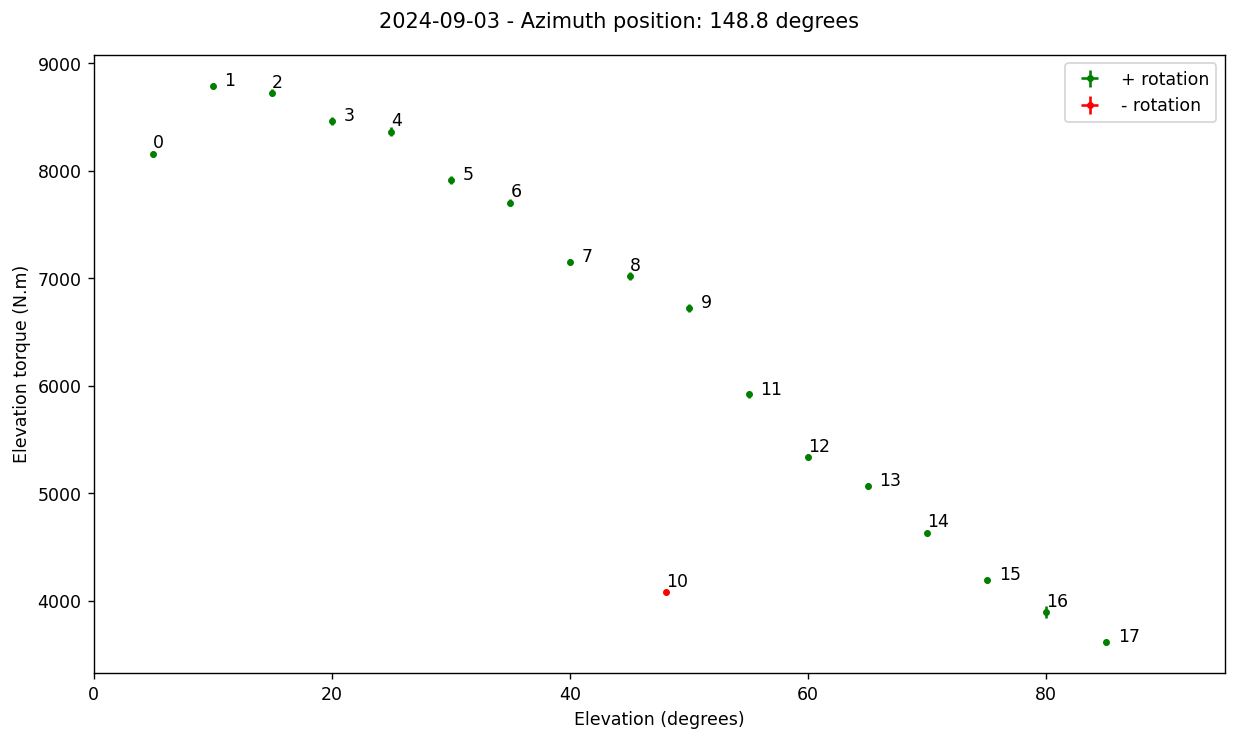

In [10]:
# We are going to plot the Torque as a function of the elevation angle for a given position of the TMA in azimuth
# So we will first identify what is the most common TMA position in azimuth over all the overlap periods and we will make the analysis for this
# position only
az_min, az_max = get_common_azimuth(overlaps, client)

# Create pandas dataframe with the relevant EFD data
df = make_dataframe(overlaps, client, az_min, az_max)

# Plot torque versus elevation angle
plot_torque_versus_elevation(df, date, 0.5 * (az_max + az_min), plot_dir)

## Plot data in chronological order

It is useful to plot a few quantities in chronological order in order to be able to understand the exact sequence of events

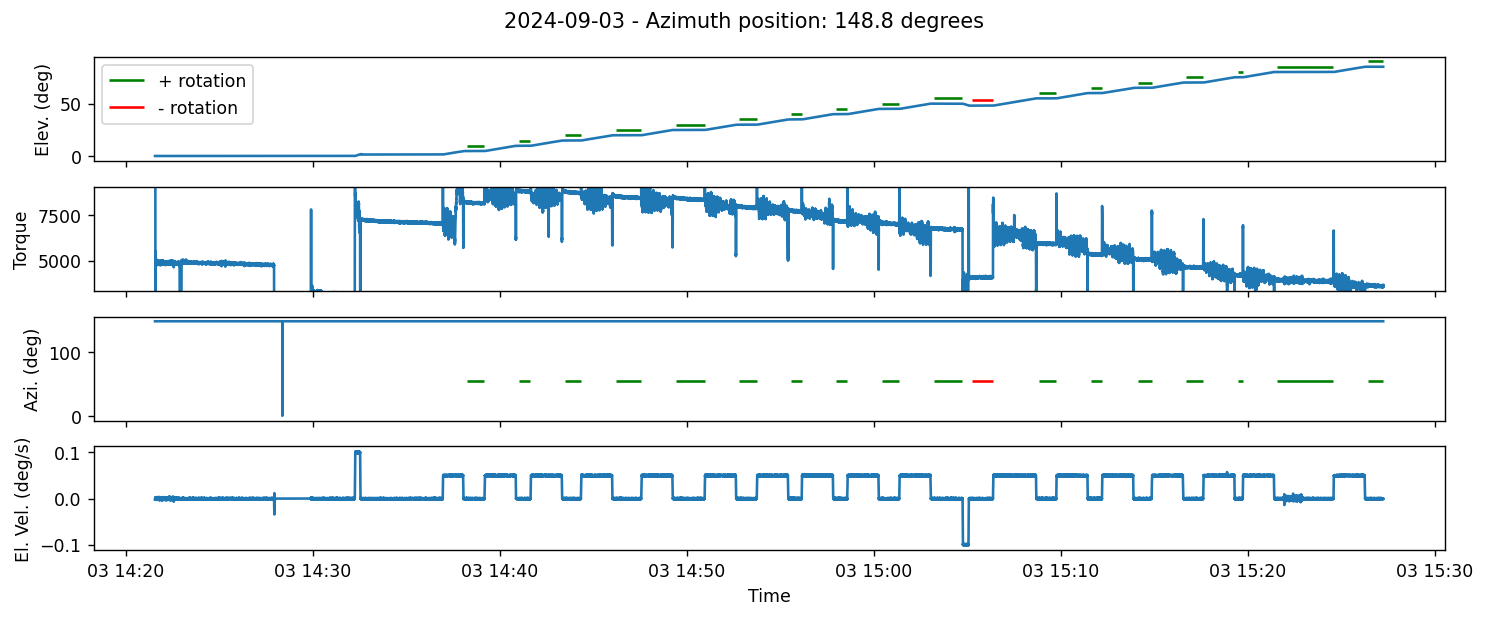

In [11]:
# We will retrieve data back t_back seconds in the past
t_back = 1000
plot_history(
    df, client, t_back, date, 0.5 * (az_max + az_min), plot_dir, save_plot=True
)